In [1]:
import numpy as np
import pandas as pd
import featuretools as ft

In [2]:
employee_history = pd.read_pickle('../data/interim/employee.pkl')
relatives_history = pd.read_pickle('../data/interim/relatives.pkl')
ogrv_history = pd.read_pickle('../data/interim/ogrv.pkl')

In [3]:
sub_df = pd.read_csv('../data/submissions/submission_check.csv', sep=';', parse_dates=['date'])

Будем собирать датасет из пар (id, target_date), рассчитывая фичи на последнюю доступную дату для данного target_date

In [4]:
dataset = pd.concat((employee_history[['hash_tab_num', 'date']], sub_df[['hash_tab_num', 'date']]), ignore_index=True)

In [5]:
# выкидываем семплы до 2015-09-01 - они будут использоваться только для расчета фич других объектов
dataset = dataset.drop(dataset[dataset['date'] < '2015-09-01'].index)
dataset = dataset.reset_index(drop=True)
dataset.index.name = 'row_id'

In [6]:
# объект моделирования - пара (employee, date)
dataset.head(2)

,hash_tab_num,date
row_id,,
0,0,2015-09-01
1,0,2015-10-01


# Описание данных для featuretools

In [7]:
# проставим даты отсечки по расчету фичей
cutoff_times = dataset[['date']].copy()
cutoff_times['time'] = pd.to_datetime('2015-08-01')
cutoff_times.loc[cutoff_times['date'] > '2016-08-01', 'time'] = pd.to_datetime('2016-08-01')
cutoff_times.loc[cutoff_times['date'] > '2017-08-01', 'time'] = pd.to_datetime('2017-08-01')
cutoff_times.loc[cutoff_times['date'] > '2018-08-01', 'time'] = pd.to_datetime('2018-08-01')
cutoff_times.loc[cutoff_times['date'] > '2019-08-01', 'time'] = pd.to_datetime('2019-08-01')
cutoff_times = cutoff_times.drop('date', axis=1)

In [8]:
cutoff_times.head(2)

,time
row_id,
0,2015-08-01
1,2015-08-01


In [9]:
es = ft.EntitySet()
es = es.entity_from_dataframe(
    entity_id='dataset',
    dataframe=dataset.reset_index(),
    index='row_id',
    variable_types={
        'hash_tab_num': ft.variable_types.Id,
        'date': ft.variable_types.Datetime,
    },
)

In [10]:
# нужно выделить таблицу сотрудников с неизменными во времени показателями
employee = employee_history[['hash_tab_num', 'date_of_birth', 'is_local', 'gender', 'education']].drop_duplicates()
employee_history = employee_history.drop(['date_of_birth', 'is_local', 'gender', 'education'], axis=1)

es = es.entity_from_dataframe(
    entity_id='employee',
    dataframe=employee,
    index='hash_tab_num',
    variable_types={
        'date_of_birth': ft.variable_types.DateOfBirth,
        'is_local': ft.variable_types.Boolean,
        'gender': ft.variable_types.Boolean,
    },
)

In [11]:
employee_history.index.name = 'row_id'

es = es.entity_from_dataframe(
    entity_id='employee_history',
    dataframe=employee_history.reset_index(),
    index='row_id',
    time_index='date',
    variable_types={
        'hash_tab_num': ft.variable_types.Id,
        'razryad_post': ft.variable_types.Ordinal,
        'razryad_fact': ft.variable_types.Ordinal,
        'child_num': ft.variable_types.Ordinal,
        'sick': ft.variable_types.Boolean,
        'is_married': ft.variable_types.Boolean,
    },
)

In [12]:
# добавим гендер родственника
relatives_history['is_male'] = relatives_history['rel_type'].isin(['Сын', 'Муж', 'Отец', 'Пасынок', 'Внук','Брат']).astype('int')
relatives_history.index.name = 'row_id'

es = es.entity_from_dataframe(
    entity_id='relatives_history',
    dataframe=relatives_history.reset_index(),
    index='row_id',
    variable_types={
        'hash_tab_num': ft.variable_types.Id,
        'rel_birth': ft.variable_types.DateOfBirth,
        'is_male': ft.variable_types.Boolean,
    },
)

In [13]:
ogrv_history.index.name = 'row_id'

es = es.entity_from_dataframe(
    entity_id='ogrv_history',
    dataframe=ogrv_history.reset_index(),
    index='row_id',
    time_index='date',
    variable_types={'hash_tab_num': ft.variable_types.Id},
)

In [14]:
# sick dates entity
es = es.entity_from_dataframe(
    entity_id='sick_dates',
    dataframe=employee_history[employee_history['sick'] == 1][['hash_tab_num', 'date']].reset_index(),
    index='row_id',
    time_index='date',
    variable_types={'hash_tab_num': ft.variable_types.Id},
)

In [15]:
es = es.add_relationships([
    ft.Relationship(es['employee']['hash_tab_num'], es['employee_history']['hash_tab_num']),
    ft.Relationship(es['employee']['hash_tab_num'], es['relatives_history']['hash_tab_num']),
    ft.Relationship(es['employee']['hash_tab_num'], es['ogrv_history']['hash_tab_num']),
    ft.Relationship(es['employee']['hash_tab_num'], es['dataset']['hash_tab_num']),
    ft.Relationship(es['employee']['hash_tab_num'], es['sick_dates']['hash_tab_num']),
])

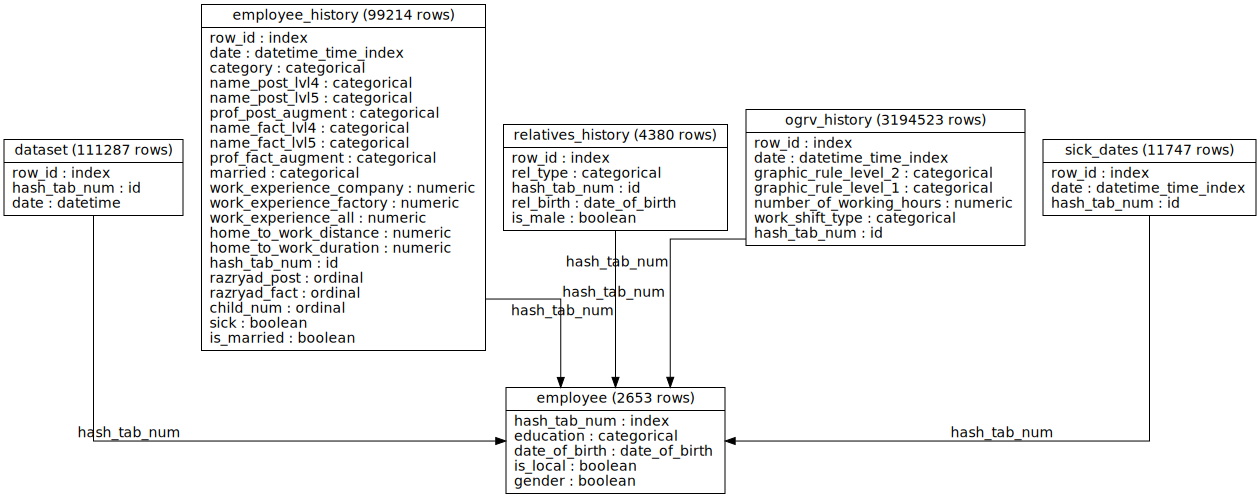

In [16]:
es.plot()

In [17]:
es['employee_history']['sick'].interesting_values = [1]
es['ogrv_history']['graphic_rule_level_1'].interesting_values = ['Больничный', 'Прогул', 'Командировка']
es['employee']['gender'].interesting_values = [1]
es['employee']['is_local'].interesting_values = [1]

# DFS

In [18]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_entity='dataset',
    agg_primitives=['sum', 'std', 'max', 'min', 'mean', 'count', 'percent_true', 'num_unique', 'mode', 'avg_time_between', 'time_since_first', 'median'],
    trans_primitives=['year', 'month', 'age', 'time_since_previous'],
    where_primitives=['avg_time_between', 'count'],
    cutoff_time=cutoff_times.reset_index(),
    max_depth=3,
    n_jobs=32,
    verbose=True,
)

Built 155 features
EntitySet scattered to 32 workers in 14 seconds
Elapsed: 00:26 | Progress: 100%|██████████


In [19]:
# remove constant features
feature_matrix, feature_defs = ft.selection.remove_single_value_features(feature_matrix, features=feature_defs)

In [21]:
object_cols = feature_matrix.select_dtypes('object').columns
# нужно заполнить NaN в строковых признаках и вернуть им категориальный тип
feature_matrix[object_cols] = feature_matrix[object_cols].fillna('None').astype('category')

# External data

In [22]:
dataset = dataset.merge(feature_matrix.drop('hash_tab_num', axis=1), left_index=True, right_index=True, validate='1:1')

In [23]:
dataset = dataset.merge(cutoff_times, left_index=True, right_index=True, validate='1:1')

In [24]:
dataset = dataset.rename(columns={'time': 'cutoff_date'})

In [25]:
dataset['cutoff_year'] = dataset['cutoff_date'].dt.year
dataset['cutoff_month'] = dataset['cutoff_date'].dt.month

In [26]:
economic_df = pd.read_csv('../data/external/economic_indicators.csv')
res_df = pd.read_csv('../data/external/mineral_resources_price_history.csv', parse_dates=['date'])

In [27]:
economic_df['next_year'] = economic_df['year'].shift(-1)

In [28]:
economic_df = economic_df.dropna()

In [29]:
economic_df = economic_df.drop('year', axis=1)

In [30]:
dataset = dataset.merge(economic_df, left_on='cutoff_year', right_on='next_year', how='left')

In [31]:
dataset = dataset.drop('next_year', axis=1)

In [32]:
res_df['next_year'] = res_df['date'].shift(1).dt.year
res_df['next_month'] = res_df['date'].shift(1).dt.month

In [33]:
res_df = res_df.dropna()

In [34]:
res_df = res_df.groupby(['next_year', 'next_month'], as_index=False).agg(['sum', 'mean']).reset_index()
res_df.columns = ['_'.join(col).strip() for col in res_df.columns.values]
res_df = res_df.rename(columns={'next_year_': 'next_year', 'next_month_': 'next_month'})

In [35]:
dataset = dataset.merge(res_df, left_on=['cutoff_year', 'cutoff_month'], right_on=['next_year', 'next_month'], how='left')

In [36]:
dataset = dataset.drop(['next_year', 'next_month'], axis=1)

# Additional features

In [37]:
rel_ages = dataset[['hash_tab_num', 'date', 'cutoff_date']]
rel_ages = rel_ages.merge(relatives_history, on='hash_tab_num')
rel_ages['cutoff_age'] = rel_ages['cutoff_date'].dt.year - rel_ages['rel_birth']

In [38]:
rel_ages['is_pensioner'] = 0
rel_ages.loc[(rel_ages['cutoff_age'] > 55) & ~rel_ages['is_male'], 'is_pensioner'] = 1
rel_ages.loc[(rel_ages['cutoff_age'] > 60) & rel_ages['is_male'], 'is_pensioner'] = 1
rel_ages['is_predschool'] = 0
rel_ages.loc[rel_ages['cutoff_age'] < 7, 'is_predschool'] = 1

In [39]:
rel_ages_1 = rel_ages.groupby(['hash_tab_num', 'date'])[['is_pensioner', 'is_predschool']].sum().reset_index()
rel_ages_1 = rel_ages_1.rename(columns={'is_pensioner': 'n_pensioners', 'is_predschool': 'n_predschools'})
mean_rel_age = rel_ages.groupby(['hash_tab_num', 'date'])['cutoff_age'].mean().reset_index()
mean_rel_age = mean_rel_age.rename(columns={'cutoff_age': 'mean_rel_age'})

In [40]:
dataset = dataset.merge(rel_ages_1, on=['hash_tab_num', 'date'], how='left')
dataset = dataset.merge(mean_rel_age, on=['hash_tab_num', 'date'], how='left')

In [41]:
ogrvs = dataset[['hash_tab_num', 'date', 'cutoff_date']]
ogrvs = ogrvs.merge(ogrv_history, left_on=['hash_tab_num', 'cutoff_date'], right_on=['hash_tab_num', 'date'], suffixes=(None, '_cutoff'))
ogrvs = ogrvs.drop('date_cutoff', axis=1)

In [42]:
ogrvs['is_smena'] = ogrvs['work_shift_type'].str.startswith('Смена').astype('int')
n_watches = ogrvs.groupby(['hash_tab_num', 'cutoff_date'], as_index=False)['is_smena'].agg(['sum', 'mean']).reset_index()
n_watches = n_watches.rename(columns={'sum': 'watches_sum', 'mean': 'watches_mean'})

In [43]:
dataset = dataset.merge(n_watches, on=['hash_tab_num', 'cutoff_date'], how='left')

In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111287 entries, 0 to 111286
Columns: 171 entries, hash_tab_num to watches_mean
dtypes: category(13), datetime64[ns](2), float64(144), int64(12)
memory usage: 136.4 MB


In [45]:
dataset.to_pickle('../data/interim/features.pkl')

# Target merging

In [21]:
train = dataset[dataset['date'] < '2019-09-01'].copy()
test = dataset[dataset['date'] >= '2019-09-01'].copy()

In [22]:
train = train.merge(employee_history[['sick', 'hash_tab_num', 'date']], on=['hash_tab_num', 'date'], validate='1:1')

In [23]:
y_train = train['sick']
X_train = train.drop(['date', 'sick'], axis=1)

In [24]:
X_test = test.drop('date', axis=1)

# Catboost

In [25]:
from catboost import CatBoostClassifier

In [26]:
cat_cols = X_train.select_dtypes('category').columns.tolist()
cat_features = [idx for idx, col in enumerate(X_train.columns) if col in cat_cols]

In [27]:
clf = CatBoostClassifier()
clf.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.07046
0:	learn: 0.6386301	total: 109ms	remaining: 1m 49s
1:	learn: 0.5934096	total: 154ms	remaining: 1m 16s
2:	learn: 0.5543519	total: 198ms	remaining: 1m 5s
3:	learn: 0.5217303	total: 237ms	remaining: 59s
4:	learn: 0.4946824	total: 275ms	remaining: 54.8s
5:	learn: 0.4716346	total: 315ms	remaining: 52.1s
6:	learn: 0.4530378	total: 352ms	remaining: 49.9s
7:	learn: 0.4366727	total: 397ms	remaining: 49.2s
8:	learn: 0.4242510	total: 434ms	remaining: 47.8s
9:	learn: 0.4136733	total: 468ms	remaining: 46.4s
10:	learn: 0.4040466	total: 508ms	remaining: 45.7s
11:	learn: 0.3953497	total: 546ms	remaining: 45s
12:	learn: 0.3880567	total: 584ms	remaining: 44.3s
13:	learn: 0.3818285	total: 622ms	remaining: 43.8s
14:	learn: 0.3766092	total: 659ms	remaining: 43.3s
15:	learn: 0.3722275	total: 699ms	remaining: 43s
16:	learn: 0.3686216	total: 739ms	remaining: 42.7s
17:	learn: 0.3653847	total: 778ms	remaining: 42.4s
18:	learn: 0.3626095	total: 815ms	remaining: 42.1s
19:	learn: 0.360

In [28]:
y_test = clf.predict(X_test)

In [32]:
sub = test[['hash_tab_num', 'date']]

In [34]:
sub['target'] = y_test

In [35]:
sub.to_csv('../data/submissions/ft-ctb-attempt1.csv', index=False, sep=';')